In [1]:
!pip install pulp
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import random
random.seed(1447)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 48.4 MB/s eta 0:00:00


In [2]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [3]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>


## Import Data

#### Manufacturing variable costs

In [4]:
# Import Costs
manvar_costs = pd.read_excel('/content/variable costs.xlsx', index_col = 0)
manvar_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


#### Freight costs

In [5]:
# Import Costs
freight_costs = pd.read_excel('/content/freight costs.xlsx', index_col = 0)
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


#### Variable Costs

In [6]:
# Factory + Freight Variable Costs
var_cost = freight_costs/1000 + manvar_costs
var_cost

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


#### Fixed Costs

In [7]:
# Factory Fixed Costs
fixed_costs = pd.read_excel('/content/fixed cost.xlsx', index_col = 0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


#### Plants Capacity

In [8]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel('/content/capacity.xlsx', index_col = 0)
cap

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


#### Demand

In [9]:
# Demand by Market
demand = pd.read_excel('/content/demand.xlsx', index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


## Initial Calculation
(1 Scenario)

In [10]:
# Define Decision Variables
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
prod_name = [(i,j) for i in loc for j in loc]

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_",
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])

# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc],
                        columns = ['Plant Opening'])
df_bool

Status: Optimal
Total Costs: 65,118,000 ($/Month)


/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


#### Plant Opening

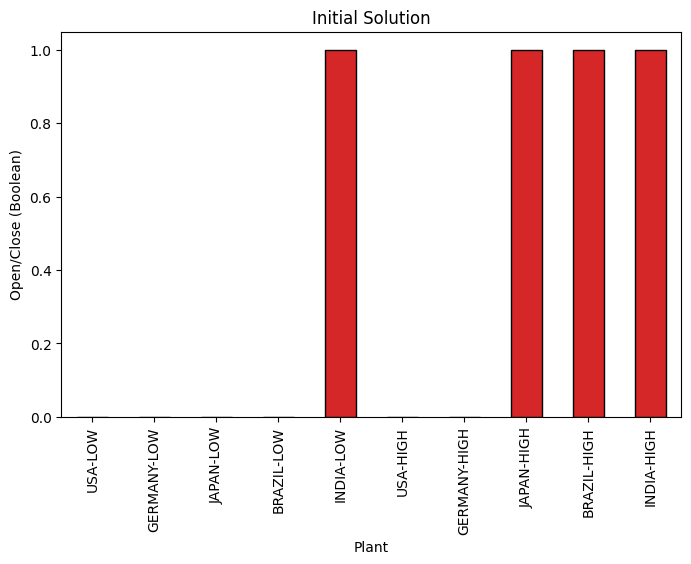

In [12]:
# Plant Opening
cap_plot = cap.copy()

ax = df_bool.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:red', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

### Functions to simulate several scenarios
#### Funtion to build the model

In [13]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_",
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])
    # Solve Model
    model.solve()

    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

#### Build the normal distribution of demand: N(demand, demand x COV)

In [14]:
# Normal Distribution
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
# Demand
CV = 0.5
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('/content/demand.xlsx'.format(int(CV * 100)))

df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,0,39829,1682416,151471,232505
1,2,895489,126023,2409467,204175,284268
2,3,4035958,101398,1955034,147743,208305
3,4,3994311,107548,1033597,216656,149191


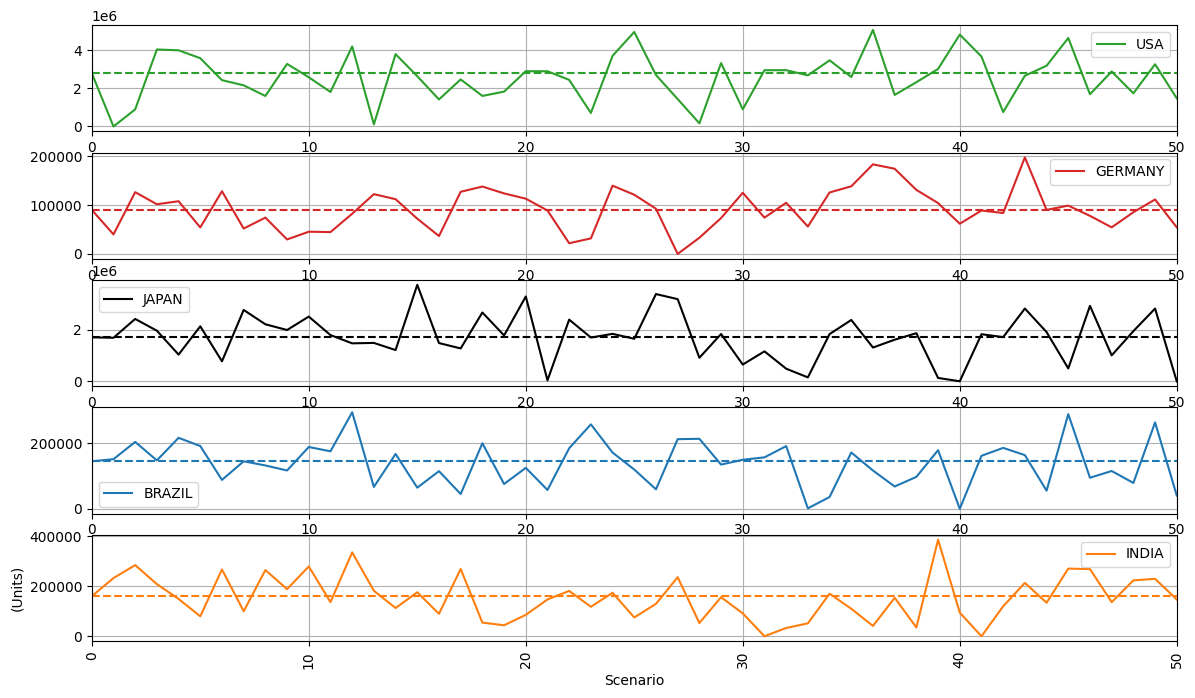

In [16]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(14, 8), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

#### Calculation: Initial Scenario

In [17]:
# Record results per scenario
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc],
                        columns = ['INITIAL'])
df_bool.head()

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,INITIAL
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0


In [18]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)

    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel('/content/boolean-50PC.xlsx'.format(int(CV * 100)))
# Other Results
df_bool.head()

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
JAPAN-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRAZIL-LOW,0,1,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0
INDIA-LOW,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,1,1


### Final Plot
#### Boolean Alone

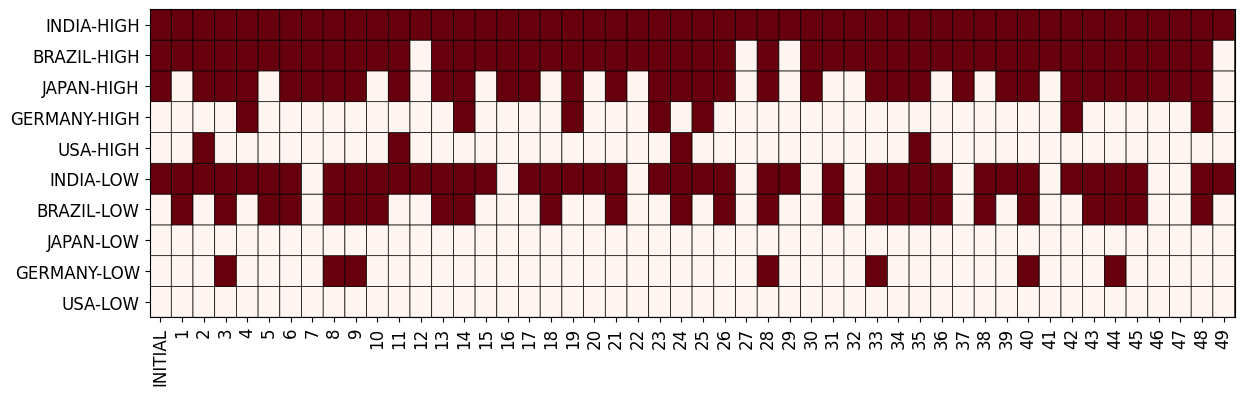

In [19]:
# Plot the Grid
plt.figure(figsize = (14,4))
plt.pcolor( df_bool, cmap = 'Reds', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.show()

#### Add Demand

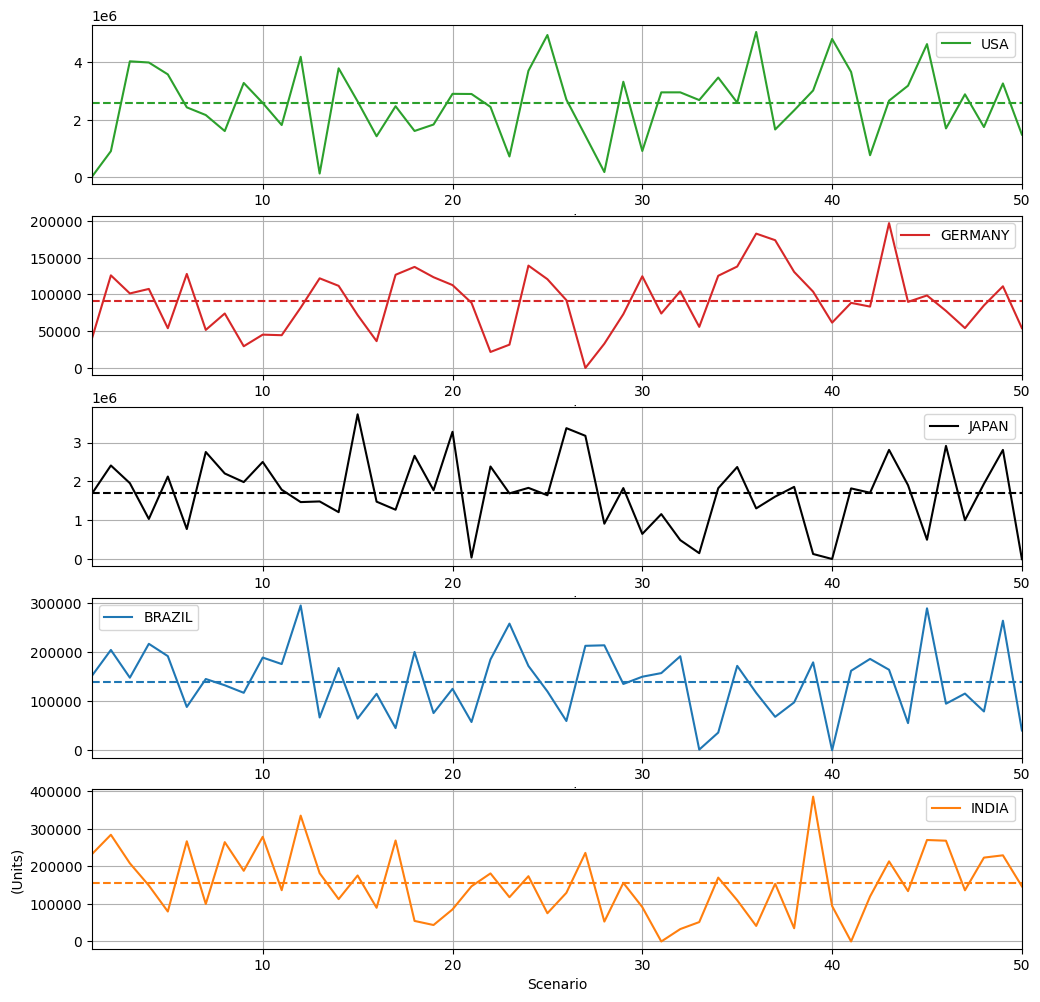

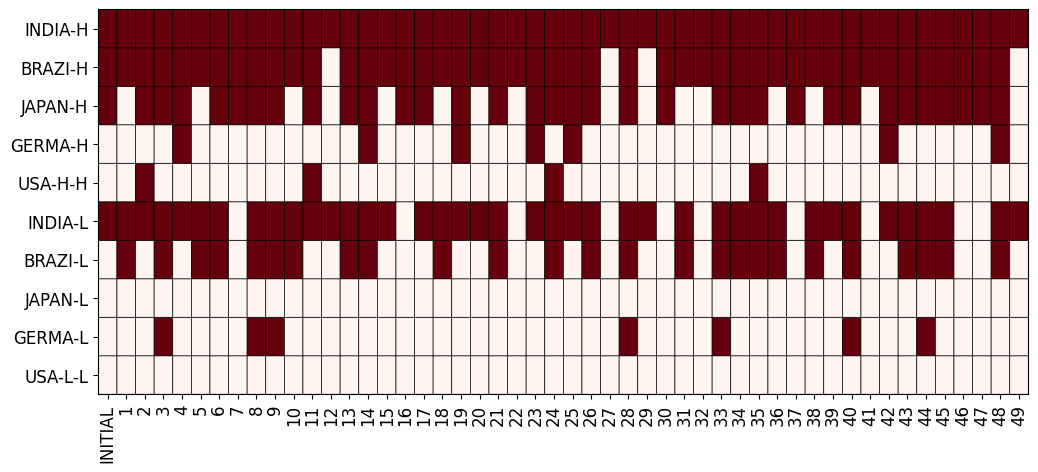

In [20]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(12, 12), xlim=[1,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].mean(), color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')

# add the scenario plot
plt.figure(figsize=(12, 5))
plt.pcolor(df_bool, cmap = 'Reds', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], [d[0:5]+ '-H' * ('HIGH' in d) + '-L' * ('LOW' in d) for d in df_bool.index], fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Find the optimal Solution
#### Unique Combinations

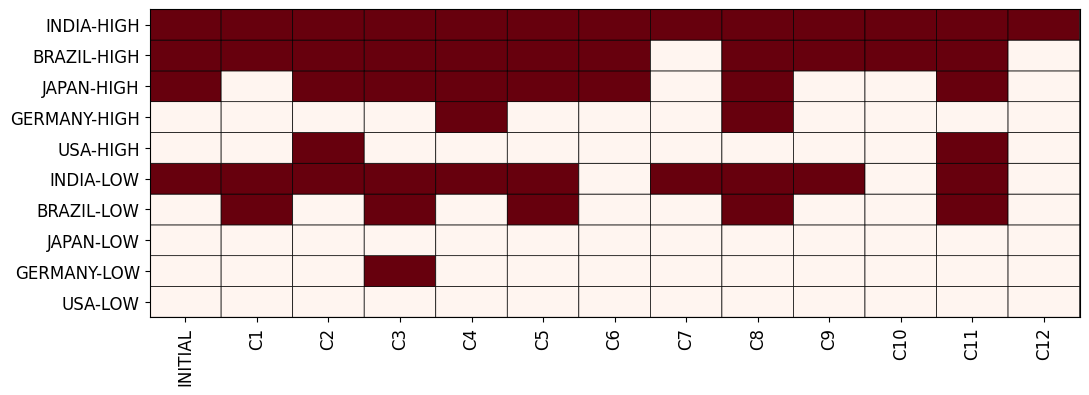

In [21]:
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Reds', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

#### Number of Combinations

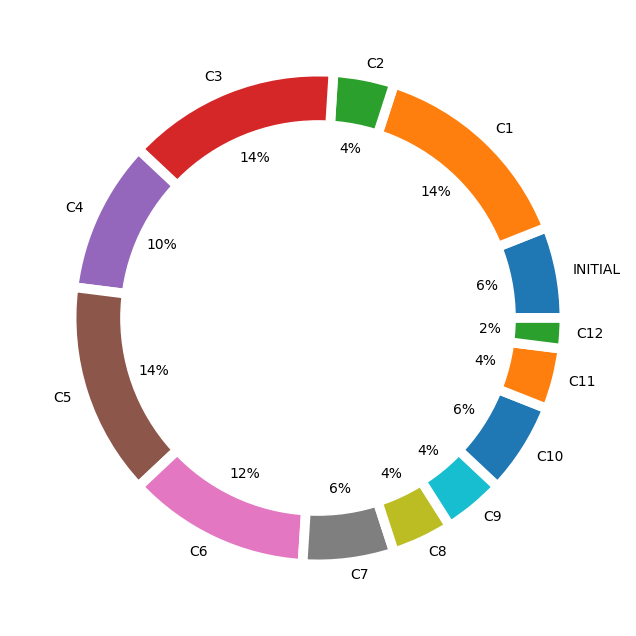

In [22]:
# Number of columns
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2]!=df_unique[col1]).sum()==0:
            count += 1
    COL_NUMBER.append(count)
df_comb = pd.DataFrame({'column':COL_NAME, 'count':COL_NUMBER}).set_index('column')

my_circle = plt.Circle( (0,0), 0.8, color='white')
df_comb.plot.pie(figsize=(10, 8), x='column', y='count', legend= False, pctdistance=0.7,
                                          autopct='%1.0f%%', labeldistance=1.05,
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'White' })
plt.xlabel('Business Vertical')
# plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()